# CNN Classifier Training Example

This notebook demonstrates a basic 4-layer CNN trained to classify spectra from galaxies and galaxies + SNe of several types within 2 weeks (plus/minus) of max light. In this notebook the classifier assumes we can work in the host rest frame.

Required software:
* TensorFlow2
* [desihub software](https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop) (with usual dependencies).

Adding more spectral categories is straightforward.

In [1]:
from desispec.io import read_spectra
from desitrip.preproc import rebin_flux, rescale_flux

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

import os
import platform

In [2]:
mpl.rc('font', size=14)

## Input Spectra

Input DESI spectra, rebin and rescale them, and then divide them into training and test sets for the classifier.

In [3]:
def condition_spectra(coadd_files, truth_files):
    """Read DESI spectra, rebin to a subsampled logarithmic wavelength grid, and rescale.
    
    Parameters
    ----------
    coadd_files : list or ndarray
        List of FITS files on disk with DESI spectra.
    truth_files : list or ndarray
        Truth files.
    
    Returns
    -------
    fluxes : ndarray
        Array of fluxes rebinned to a logarithmic wavelength grid.
    """
    fluxes = None
    
    for cf, tf in zip(coadd_files, truth_files):
        spectra = read_spectra(cf)
        wave = spectra.wave['brz']
        flux = spectra.flux['brz']
        ivar = spectra.ivar['brz']
        
        objtruth = Table.read(tf, 'OBJTRUTH')
        truth = Table.read(tf, 'TRUTH')
        truez = truth['TRUEZ']

#         # Pre-condition: remove spectra with NaNs and zero flux values.
#         mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
#         mask_idx = np.argwhere(mask)
#         flux = np.delete(flux, mask_idx, axis=0)
#         ivar = np.delete(ivar, mask_idx, axis=0)

        # Rebin and rescale fluxes so that each is normalized between 0 and 1.
        rewave, reflux, reivar = rebin_flux(wave, flux, ivar, truez, minwave=2500., maxwave=9500., nbins=150, log=True, clip=True)
        rsflux = rescale_flux(reflux)

        if fluxes is None:
            fluxes = rsflux
        else:
            fluxes = np.concatenate((fluxes, rsflux))
    
    return fluxes

In [4]:
host_truth = sorted(glob('../../../../../time_domain/bgs/150s/hosts/*truth.fits'))
host_coadd = sorted(glob('../../../../../time_domain/bgs/150s/hosts/*coadd.fits'))
host_flux  = condition_spectra(host_coadd, host_truth)

In [5]:
snia_truth = sorted(glob('../../../../../time_domain/bgs/150s/sn_ia/hsiao/*truth.fits'))
snia_files = sorted(glob('../../../../../time_domain/bgs/150s/sn_ia/hsiao/*coadd.fits'))
snia_flux  = condition_spectra(snia_files, snia_truth)

In [6]:
snib_truth = sorted(glob('../../../../../time_domain/bgs/150s/sn_ib/*/*truth.fits'))
snib_files = sorted(glob('../../../../../time_domain/bgs/150s/sn_ib/*/*coadd.fits'))
snib_flux  = condition_spectra(snib_files, snib_truth)

In [7]:
snic_truth = sorted(glob('../../../../../time_domain/bgs/150s/sn_ic/*/*truth.fits'))
snic_files = sorted(glob('../../../../../time_domain/bgs/150s/sn_ic/*/*coadd.fits'))
snic_flux  = condition_spectra(snic_files, snic_truth)

In [8]:
sniin_truth = sorted(glob('../../../../../time_domain/bgs/150s/sn_iin/*/*truth.fits'))
sniin_files = sorted(glob('../../../../../time_domain/bgs/150s/sn_iin/*/*coadd.fits'))
sniin_flux  = condition_spectra(sniin_files, sniin_truth)

In [9]:
# sniilp_truth = sorted(glob('../../../../../time_domain/bgs/150s/sn_iilp/*/*truth.fits'))
# sniilp_files = sorted(glob('../../../../../time_domain/bgs/150s/sn_iilp/*/*coadd.fits'))
# sniilp_flux  = condition_spectra(sniilp_files, sniilp_truth)

In [10]:
sniip_truth = sorted(glob('../../../../../time_domain/bgs/150s/sn_iip/*/*truth.fits'))
sniip_files = sorted(glob('../../../../../time_domain/bgs/150s/sn_iip/*/*coadd.fits'))
sniip_flux  = condition_spectra(sniip_files, sniip_truth)

In [11]:
nhost, nbins  = host_flux.shape
nsnia, nbins  = snia_flux.shape
nsnib, nbins  = snib_flux.shape
# nsnibc, nbins = snibc_flux.shape
nsnic, nbins  = snic_flux.shape
nsniin, nbins = sniin_flux.shape
# nsniilp, nbins = sniilp_flux.shape
nsniip, nbins = sniip_flux.shape
# nhost, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nbins
nhost, nsnia, nsnib, nsnic, nsniin, nsniip, nbins

(9969, 9964, 9958, 8269, 9949, 9962, 150)

### Plot Spectra to Check Output

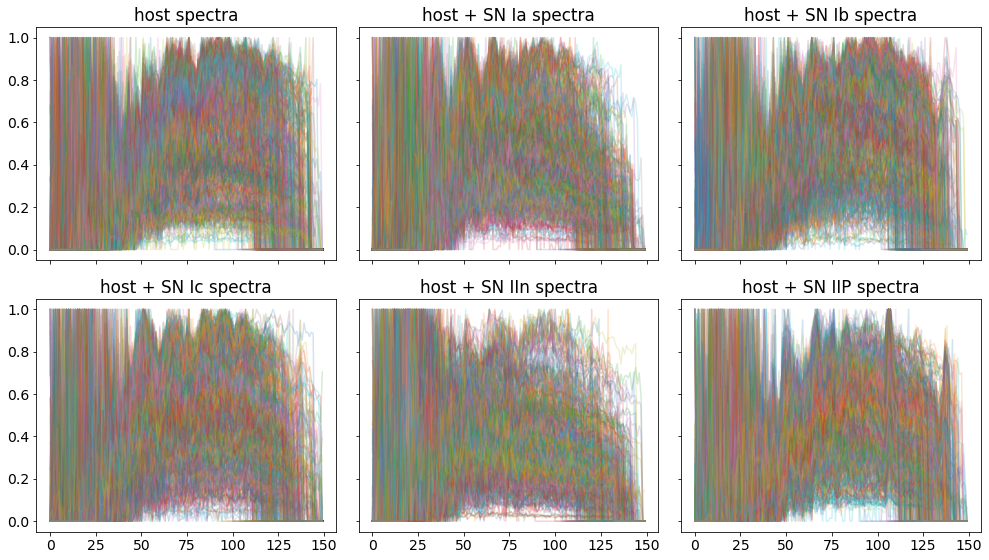

In [12]:
fig, axes = plt.subplots(2,3, figsize=(14,8), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(0,500):
    
    ax = axes[0]
    ax.plot(host_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
    ax = axes[2]
    ax.plot(snib_flux[i], alpha=0.2)
    
    ax = axes[3]
    ax.plot(snic_flux[i], alpha=0.2)
    
    ax = axes[4]
    ax.plot(sniin_flux[i], alpha=0.2)
    
    ax = axes[5]
    ax.plot(sniip_flux[i], alpha=0.2)
    
axes[0].set_title('host spectra')
axes[1].set_title('host + SN Ia spectra')
axes[2].set_title('host + SN Ib spectra')
axes[3].set_title('host + SN Ic spectra')
axes[4].set_title('host + SN IIn spectra')
axes[5].set_title('host + SN IIP spectra')

fig.tight_layout()

### Set up Training Sets and Labels

0. "host" spectra based only on BGS templates
0. "snia" spectra based on BGS + SN Ia templates
0. "snib" spectra based on BGS + SN Ib templates
0. "snic" spectra based on BGS + SN Ic templates
0. "sniin" spectra based on BGS + SN IIn templates
0. "sniip" spectra based on BGS + SN IIP templates

In [13]:
x = np.concatenate([host_flux, 
                    snia_flux,
                    snib_flux,
                    snic_flux,
                    sniin_flux,
                    sniip_flux
                   ]).reshape(-1, nbins, 1)

labels = ['Host',
          'SN Ia',
          'SN Ib',
          'SN Ic',
          'SN IIn',
          'SN IIP']
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(nhost, 0), 
                        np.full(nsnia, 1),
                        np.full(nsnib, 2),
                        np.full(nsnic, 3),
                        np.full(nsniin, 4),
                        np.full(nsniip, 5)
                       ]))

In [14]:
x.shape, y.shape

((58071, 150, 1), (58071, 6))

## CNN Network Setup

Train network with TensorFlow+Keras.

In [15]:
import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

In [16]:
def network(input_shape, ncat, learning_rate=0.0005, reg=0.0032, dropout=0.7436, seed=None):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [28]:
model = network((nbins, 1), ncat=y.shape[1])

In [29]:
model.summary()

Model: "SNnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Spec (InputLayer)      [(None, 150, 1)]          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 150, 8)            48        
_________________________________________________________________
batch_normalization_8 (Batch (None, 150, 8)            32        
_________________________________________________________________
activation_8 (Activation)    (None, 150, 8)            0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 75, 8)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 75, 16)            656       
_________________________________________________________________
batch_normalization_9 (Batch (None, 75, 16)            64    

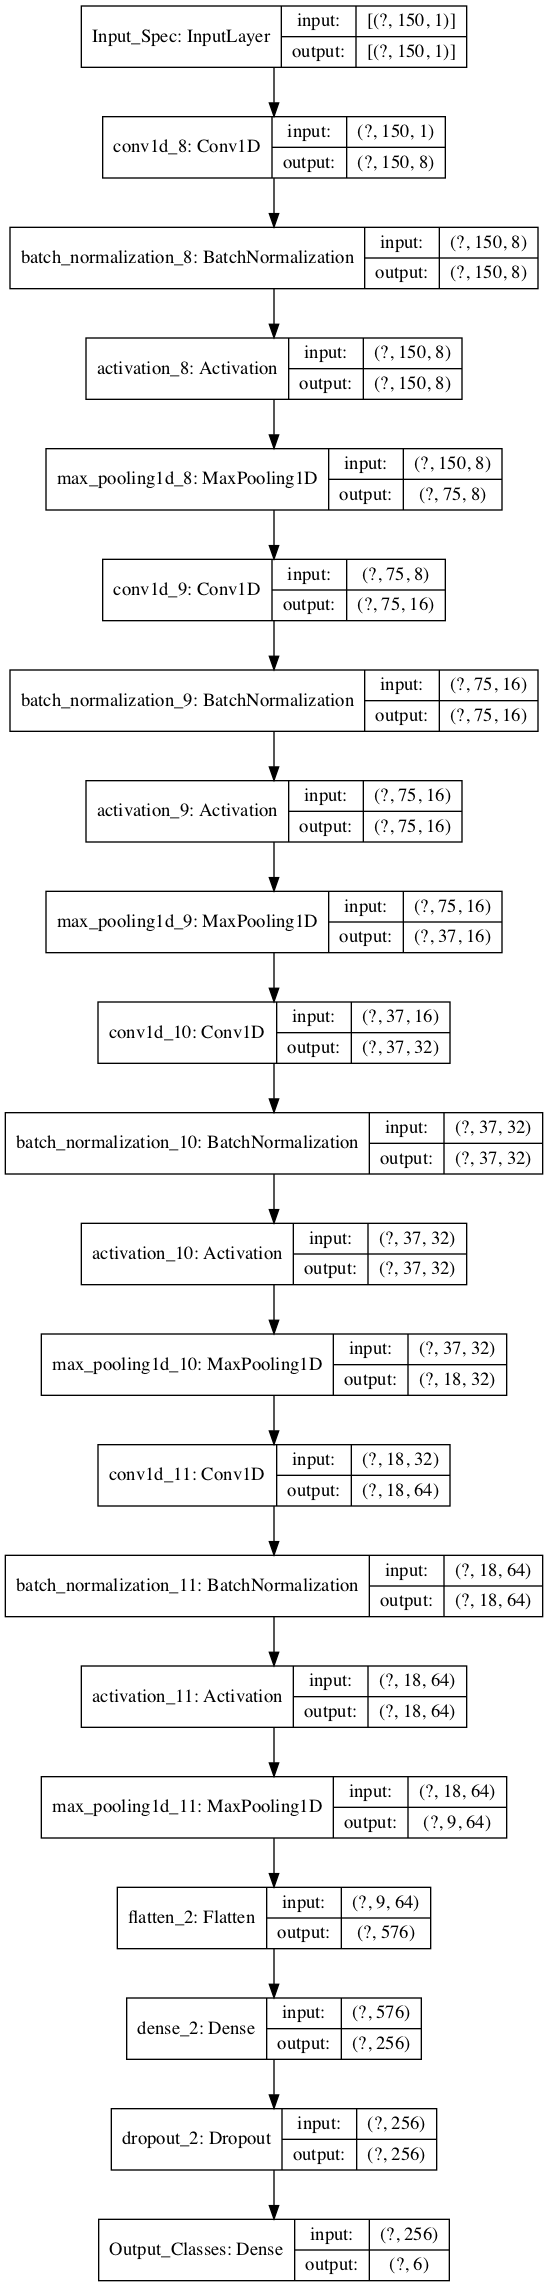

In [30]:
tf.keras.utils.plot_model(model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    )

## Train and Test

Split the data into training and testing (+ validation) samples and fit the network weights.

In [31]:
from sklearn.model_selection import train_test_split

def train_test_validate(x, y, train_size=0.75, test_size=0.125, val_size=0.125):
    # Ensure proper normalization.
    if train_size + test_size + val_size != 1:
        norm = train_size + test_size + val_size
        train_size = train_size/norm
        test_size = test_size/norm
        val_size = val_size/norm
        print('Renormalized to train {:g}, test {:g}, and validate {:g}'.format(train_size, test_size, val_size))
        
    # Split into training and testing samples.
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_size)
    
    # Split off the validation sample from the test sample.
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_size/(test_size+val_size))
    
    return x_train, x_test, x_val, y_train, y_test, y_val

In [32]:
x_train, x_test, x_val, y_train, y_test, y_val = train_test_validate(x, y, 0.6, 0.2, 0.2)

x_train.shape, x_test.shape, x_val.shape

((34842, 150, 1), (11615, 150, 1), (11614, 150, 1))

In [33]:
hist = model.fit(x_train, y_train, batch_size=65, epochs=50, validation_data=(x_test, y_test), shuffle=True)

Train on 34842 samples, validate on 11615 samples
Epoch 1/50
34842/34842 [==============================] - 22s 619us/sample - loss: 2.6104 - accuracy: 0.3375 - val_loss: 2.0647 - val_accuracy: 0.4902
Epoch 2/50
34842/34842 [==============================] - 19s 546us/sample - loss: 1.8425 - accuracy: 0.4949 - val_loss: 1.5264 - val_accuracy: 0.5994
Epoch 3/50
34842/34842 [==============================] - 19s 550us/sample - loss: 1.4903 - accuracy: 0.5776 - val_loss: 1.3192 - val_accuracy: 0.6369
Epoch 4/50
34842/34842 [==============================] - 19s 549us/sample - loss: 1.3254 - accuracy: 0.6142 - val_loss: 1.1809 - val_accuracy: 0.6624
Epoch 5/50
34842/34842 [==============================] - 19s 541us/sample - loss: 1.2208 - accuracy: 0.6403 - val_loss: 1.1538 - val_accuracy: 0.6500
Epoch 6/50
34842/34842 [==============================] - 19s 540us/sample - loss: 1.1614 - accuracy: 0.6535 - val_loss: 1.0806 - val_accuracy: 0.6716
Epoch 7/50
34842/34842 [====================

## Performance

### Loss and Accuracy

Plot loss and accuracy as a function of epoch.

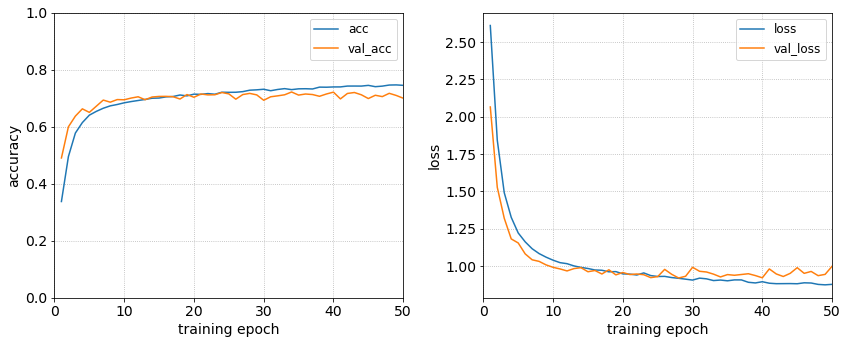

In [126]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['accuracy'], label='acc')
ax.plot(epochs, hist.history['val_accuracy'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout();
fig.savefig('6label_acc_loss.png', dpi=120)

### ROC Curve and Precision-Recall

Plot both the ROC curves per class and the class-averaged ROC curve.

In [37]:
y_pred = model.predict(x_val)
y_pred

array([[1.98597081e-05, 1.48253821e-04, 7.22028723e-04, 5.16945776e-03,
        6.01386512e-03, 9.87926483e-01],
       [1.28228121e-05, 4.72852116e-05, 1.49150100e-03, 9.94119287e-01,
        2.00133618e-05, 4.30906424e-03],
       [8.27940255e-02, 5.02743013e-02, 2.48692796e-01, 4.64651853e-01,
        1.78625211e-02, 1.35724440e-01],
       ...,
       [1.59611240e-01, 2.08361987e-02, 4.79793727e-01, 2.14433014e-01,
        6.35389332e-03, 1.18971892e-01],
       [2.14669779e-01, 5.69682159e-02, 2.65036523e-01, 2.17326254e-01,
        9.81909484e-02, 1.47808239e-01],
       [1.15555785e-07, 2.35137690e-04, 5.78351915e-01, 4.21410143e-01,
        1.93161007e-08, 2.64835830e-06]], dtype=float32)

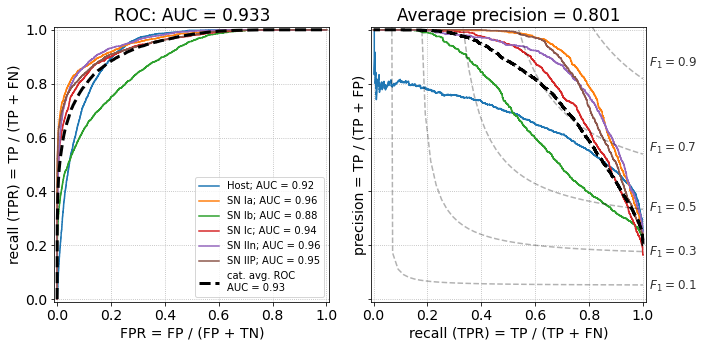

In [128]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_val[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_val.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_val, y_pred)),
       aspect='equal')

fig.tight_layout()
fig.savefig('6label_roc_pr.png', dpi=120)

### Confusion Matrix

In [130]:
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

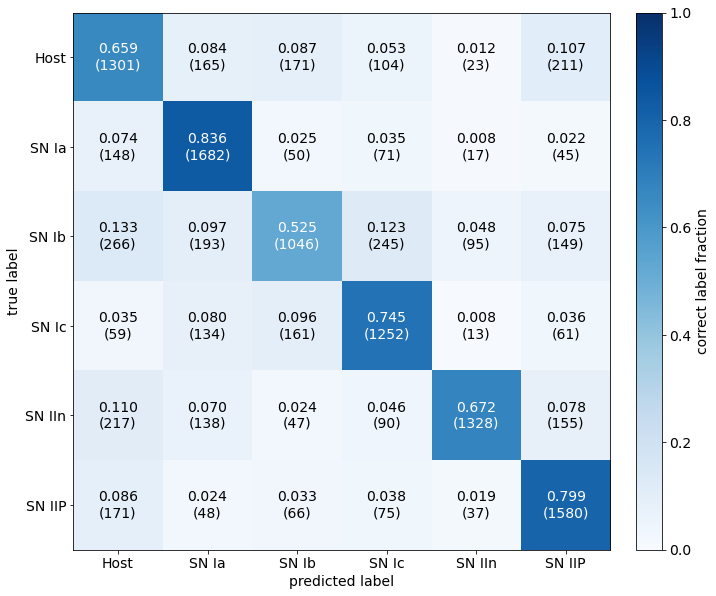

In [132]:
fig, ax = plt.subplots(1,1, figsize=(10,8.5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()
fig.savefig('6label_cm.png', dpi=120)

In [42]:
model.save('6label_cnn_restframe')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 6label_cnn_restframe/assets


In [43]:
model.save('6label_cnn_restframe.h5')

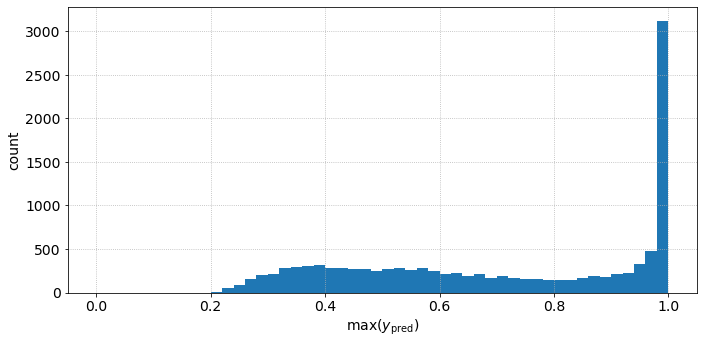

In [133]:
i = np.argmax(y_pred, axis=1)
y_max = np.max(y_pred, axis=1)

fig, ax = plt.subplots(1,1, figsize=(10,5), tight_layout=True)
ax.hist(y_max, bins=np.linspace(0,1,51))
ax.set(xlabel='$\max{(y_\mathrm{pred})}$',
       ylabel='count')
ax.grid(ls=':')
fig.savefig('max_ypred.png', dpi=120)

In [134]:
np.sum(y_max > 0.95) / len(y_max)

0.32486654038229723

In [135]:
select = y_max > 0.99

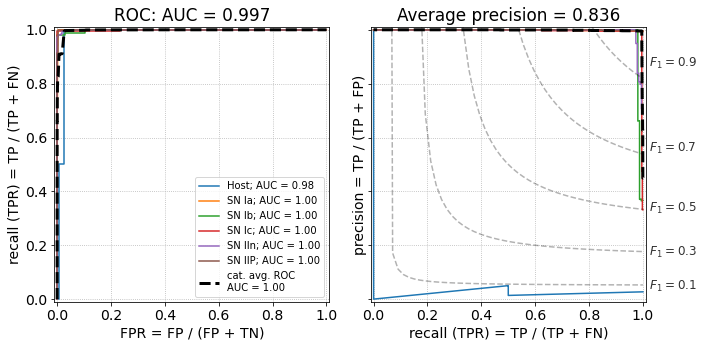

In [136]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_val[select][:,i], y_pred[select][:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_val[select][:,i], y_pred[select][:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_val[select].ravel(), y_pred[select].ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_val[select], y_pred[select])),
       aspect='equal')

fig.tight_layout()
fig.savefig('6label_roc_pr_y99.png', dpi=120)

In [137]:
# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_val[select].argmax(axis=1), y_pred[select].argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

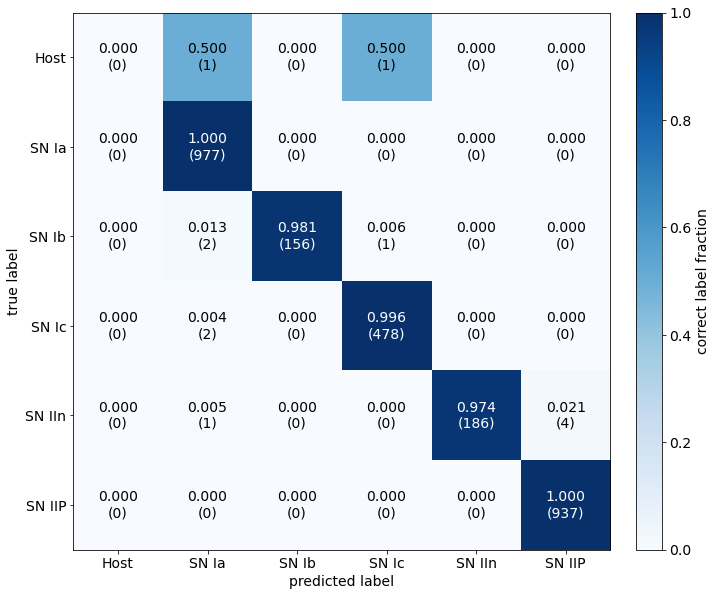

In [138]:
fig, ax = plt.subplots(1,1, figsize=(10,8.5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

# thresh = 0.5*cm.max()
thresh = np.average(cm)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()
fig.savefig('6label_cm_ygt0.99.png', dpi=120)

In [124]:
len(y_pred), len(y_pred) - np.sum(select)

(11614, 8868)